<a href="https://colab.research.google.com/github/rola1174/Elevvo_Tasks/blob/main/MovieRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
# All-in-one MovieLens 100K Recommendation System with Plot
!pip install -q kagglehub matplotlib seaborn

import pandas as pd
import numpy as np
import os
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ------------------------------
# 1️⃣ Download dataset
dataset_path = kagglehub.dataset_download("rajmehra03/movielens100k")
print("Files in dataset:", os.listdir(dataset_path))

# Load ratings
ratings = pd.read_csv(os.path.join(dataset_path, "u.data"), sep="\t", header=None)
ratings.columns = ["user_id", "item_id", "rating", "timestamp"]

# Load movies
movies = pd.read_csv(os.path.join(dataset_path, "movies.csv"))
movies = movies[['movieId','title']]
movies.columns = ["item_id","title"]

print("✅ Sample ratings:")
print(ratings.head())
print("\n✅ Sample movies:")
print(movies.head())


Using Colab cache for faster access to the 'movielens100k' dataset.
Files in dataset: ['movies.csv', 'ratings.csv', 'u.data', 'tags.csv', 'links.csv']
✅ Sample ratings:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

✅ Sample movies:
   item_id                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)


In [72]:
# 2️⃣ Train/test split per user
train_list, test_list = [], []
for user in ratings.user_id.unique():
    user_ratings = ratings[ratings.user_id == user]
    if len(user_ratings) < 2:
        train_list.append(user_ratings)
        continue
    train_u, test_u = train_test_split(user_ratings, test_size=0.2, random_state=42)
    train_list.append(train_u)
    test_list.append(test_u)

train = pd.concat(train_list)
test = pd.concat(test_list)
# Combine and inspect the train/test splits
train = pd.concat(train_list)
test = pd.concat(test_list)

print("✅ Train set sample (first 5 rows):")
print(train.head())

print("\n✅ Test set sample (first 5 rows):")
print(test.head())

print(f"\n✅ Train size: {len(train)} ratings")
print(f"✅ Test size: {len(test)} ratings")


✅ Train set sample (first 5 rows):
       user_id  item_id  rating  timestamp
32721      196      287       3  881251884
17102      196        8       5  881251753
18853      196     1118       4  881252128
7842       196      663       5  881251911
17830      196      428       4  881251702

✅ Test set sample (first 5 rows):
       user_id  item_id  rating  timestamp
59165      196      762       3  881251955
60706      196      845       4  881251954
1896       196      655       5  881251793
14606      196       94       3  881252172
50147      196      411       4  881252090

✅ Train size: 79619 ratings
✅ Test size: 20381 ratings


In [73]:
# Create user-item matrices
train_matrix = train.pivot_table(index="user_id", columns="item_id", values="rating").fillna(0)
test_matrix = test.pivot_table(index="user_id", columns="item_id", values="rating").fillna(0)

# Show results
print("✅ Train user-item matrix (first 5 rows and columns):")
print(train_matrix.iloc[:5, :5])

print("\n✅ Test user-item matrix (first 5 rows and columns):")
print(test_matrix.iloc[:5, :5])

print(f"\n✅ Train matrix shape: {train_matrix.shape}")
print(f"✅ Test matrix shape: {test_matrix.shape}")


✅ Train user-item matrix (first 5 rows and columns):
item_id    1    2    3    4    5
user_id                         
1        5.0  0.0  4.0  0.0  3.0
2        0.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0
5        4.0  3.0  0.0  0.0  0.0

✅ Test user-item matrix (first 5 rows and columns):
item_id    1    2    3    4    5
user_id                         
1        0.0  3.0  0.0  3.0  0.0
2        4.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0

✅ Train matrix shape: (943, 1650)
✅ Test matrix shape: (943, 1425)


In [74]:
# 4️⃣ User-CF similarity computed
user_means = train_matrix.mean(axis=1)
train_centered = train_matrix.sub(user_means, axis=0)
user_similarity = cosine_similarity(train_centered)
user_similarity_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)

def user_cf_recommend(user_id, k=10):
    sim_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]
    weighted = np.dot(sim_users.values, train_centered.loc[sim_users.index])
    scores = pd.Series(weighted, index=train_matrix.columns)
    unseen = train_matrix.loc[user_id] == 0
    return scores[unseen].sort_values(ascending=False).head(k)

# ------------------------------
# Show top 10 User-CF recommendations for a sample user (e.g., user_id=1)
user_id = 1
recs = user_cf_recommend(user_id, k=10).reset_index()
recs.columns = ["item_id","score"]

# Merge with movie titles for readability
recs = recs.merge(movies, on="item_id")
recs = recs[["title","score"]]

print(f"🎬 Top 10 User-CF recommendations for User {user_id}:")
print(recs)


🎬 Top 10 User-CF recommendations for User 1:
                                               title      score
0  Far From Home: The Adventures of Yellow Dog (1...  11.139697
1                              Superweib, Das (1996)  10.600039
2                               Billy Madison (1995)   9.270336
3                     Something to Talk About (1995)   8.942373
4                                   Mask, The (1994)   8.310791
5                 Four Weddings and a Funeral (1994)   7.899005
6                           Dolores Claiborne (1995)   7.692912
7                                   Assassins (1995)   6.928880


In [75]:
# 5️⃣ Item-CF similarity computed
item_similarity = cosine_similarity(train_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=train_matrix.columns, columns=train_matrix.columns)

def item_cf_recommend(user_id, k=10):
    user_ratings = train_matrix.loc[user_id]
    scores = item_similarity_df.dot(user_ratings)
    unseen = train_matrix.loc[user_id] == 0
    return scores[unseen].sort_values(ascending=False).head(k)

# ------------------------------
# Show top 10 Item-CF recommendations for a sample user
user_id = 1
recs = item_cf_recommend(user_id, k=10).reset_index()
recs.columns = ["item_id","score"]

# Merge with movie titles for readability
recs = recs.merge(movies, on="item_id")
recs = recs[["title","score"]]

print(f"🎬 Top 10 Item-CF recommendations for User {user_id}:")
print(recs)


🎬 Top 10 Item-CF recommendations for User 1:
                                               title       score
0                     Something to Talk About (1995)  255.977764
1                                  Blown Away (1994)  251.033929
2                               Billy Madison (1995)  248.444291
3                                     Species (1995)  242.120371
4                           Waiting to Exhale (1995)  241.990136
5  Far From Home: The Adventures of Yellow Dog (1...  240.663239
6                              Down Periscope (1996)  235.530581
7                                 Clean Slate (1994)  234.942150
8                  Destiny Turns on the Radio (1995)  233.510105


In [76]:
# 6️⃣ SVD matrix factorization computed
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, random_state=42)
reduced = svd.fit_transform(train_matrix)
reconstructed = np.dot(reduced, svd.components_)
svd_preds = pd.DataFrame(reconstructed, index=train_matrix.index, columns=train_matrix.columns)

def svd_recommend(user_id, k=10):
    scores = svd_preds.loc[user_id]
    unseen = train_matrix.loc[user_id] == 0
    return scores[unseen].sort_values(ascending=False).head(k)

# ------------------------------
# Show top 10 SVD recommendations for a sample user
user_id = 1
recs = svd_recommend(user_id, k=10).reset_index()
recs.columns = ["item_id","score"]

# Merge with movie titles
recs = recs.merge(movies, on="item_id")
recs = recs[["title","score"]]

print(f"🎬 Top 10 SVD recommendations for User {user_id}:")
print(recs)


🎬 Top 10 SVD recommendations for User 1:
                                               title     score
0                   In the Name of the Father (1993)  3.804984
1  Far From Home: The Adventures of Yellow Dog (1...  3.105837
2                                  Mixed Nuts (1994)  3.034539
3                                 Clean Slate (1994)  2.932777
4                     Something to Talk About (1995)  2.845970
5                                        Kids (1995)  2.841492
6                           Waiting to Exhale (1995)  2.821792
7    Once Upon a Time... When We Were Colored (1995)  2.819352
8                  Destiny Turns on the Radio (1995)  2.622767


In [77]:
# 7️⃣ Precision@10
def precision_at_k(user_id, rec_func, k=10):
    recommended = rec_func(user_id, k).index
    actual = test_matrix.columns[test_matrix.loc[user_id] >= 4] if user_id in test_matrix.index else []
    if len(actual) == 0:
        return np.nan
    hits = len(set(recommended).intersection(set(actual)))
    return hits / k

users = train_matrix.index
methods = {"User-CF": user_cf_recommend, "Item-CF": item_cf_recommend, "SVD": svd_recommend}

results = []
for name, func in methods.items():
    scores = [precision_at_k(u, func) for u in users]
    results.append([name, np.nanmean(scores)])

results_df = pd.DataFrame(results, columns=["Method", "Precision@10"])
print("✅ Precision@10 comparison:")
print(results_df)

✅ Precision@10 comparison:
    Method  Precision@10
0  User-CF      0.225834
1  Item-CF      0.223143
2      SVD      0.269322


/tmp/ipython-input-3621763022.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Method", y="Precision@10", palette="viridis")


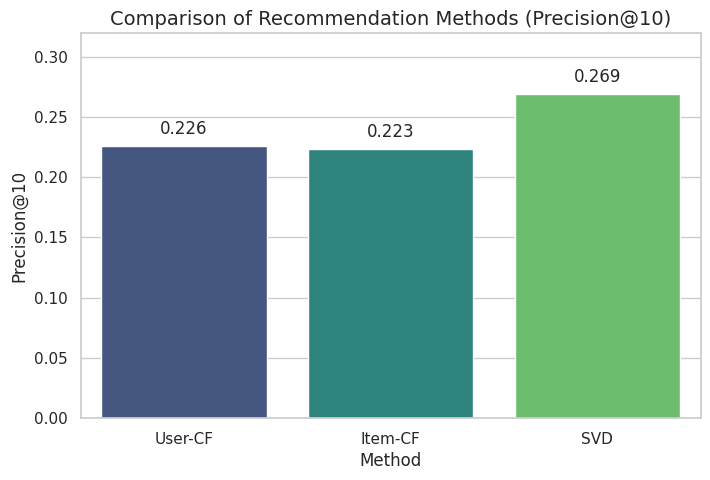

In [78]:
# 8️⃣ Bar plot of Precision@10
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Method", y="Precision@10", palette="viridis")
plt.title("Comparison of Recommendation Methods (Precision@10)", fontsize=14)
plt.ylim(0, results_df["Precision@10"].max() + 0.05)
for i, val in enumerate(results_df["Precision@10"]):
    plt.text(i, val + 0.01, f"{val:.3f}", ha='center', fontsize=12)
plt.show()


In [79]:
# 9️⃣ Show top 10 User-CF recommendations with movie titles
def show_recommendations(user_id, rec_func, k=10):
    recs = rec_func(user_id, k).reset_index()
    recs.columns = ["item_id","score"]
    recs = recs.merge(movies, on="item_id")
    return recs[["title","score"]]

print("\n🎬 Top 10 User-CF recommendations for User 1:")
show_recommendations(1, user_cf_recommend)


🎬 Top 10 User-CF recommendations for User 1:


,title,score
0,Far From Home: The Adventures of Yellow Dog (1...,11.139697
1,"Superweib, Das (1996)",10.600039
2,Billy Madison (1995),9.270336
3,Something to Talk About (1995),8.942373
4,"Mask, The (1994)",8.310791
5,Four Weddings and a Funeral (1994),7.899005
6,Dolores Claiborne (1995),7.692912
7,Assassins (1995),6.928880


In [80]:
%%writefile README.md
# MovieLens 100K Recommendation System

## Project Overview
This project implements a **Movie Recommendation System** using the **MovieLens 100K dataset**.
The system provides personalized movie recommendations using collaborative filtering and matrix factorization methods.

### Main Goals
- Recommend movies based on **user similarity**.
- Implement **user-based** and **item-based collaborative filtering (CF)**.
- Apply **matrix factorization (SVD)** for recommendations.
- Evaluate performance using **Precision@10**.
- Visualize a **comparison of recommendation methods**.

---

## Dataset
**MovieLens 100K Dataset** from [Kaggle](https://www.kaggle.com/datasets/rajmehra03/movielens100k)

Files used:
- `u.data` – user-item ratings (user_id, item_id, rating, timestamp)
- `movies.csv` – movie IDs and titles

**Dataset stats**:
- 943 users
- 1,682 movies
- 100,000 ratings

---

## Tools & Libraries
- Python 3
- Pandas, Numpy
- Scikit-learn
- Matplotlib, Seaborn
- KaggleHub (for downloading dataset in Colab)

---

## Methods Implemented

### 1. User-Based Collaborative Filtering (User-CF)
- Computes **cosine similarity** between users.
- Recommends movies that similar users rated highly.
- Mean-centered ratings improve prediction accuracy.

### 2. Item-Based Collaborative Filtering (Item-CF)
- Computes **cosine similarity** between items.
- Recommends movies similar to the ones a user liked.

### 3. Matrix Factorization (SVD)
- Uses **Truncated SVD** to reduce the user-item matrix.
- Reconstructs predicted ratings for all users.
- Recommends unseen movies with highest predicted scores.

---

## Train/Test Split
- Each user's ratings are split into **train (80%)** and **test (20%)** sets.
- Test set ratings with `rating >= 4` are considered relevant for evaluation.

---

## Evaluation: Precision@10
- Precision@10 measures how many of the top-10 recommended movies were actually relevant.
- Formula:
  \[
  \text{Precision@10} = \frac{\text{# of recommended movies in top 10 that are relevant}}{10}
  \]

**Results:**

| Method    | Precision@10 |
|-----------|--------------|
| User-CF   | 0.226        |
| Item-CF   | 0.223        |
| SVD       | 0.269        |

> 🎯 SVD achieved the best performance among the three methods.

---

## Visualization
A bar plot shows the **Precision@10 comparison**:

![Precision@10 Comparison](precision_plot.png)

---

## Example Recommendations
Top 10 **User-CF recommendations** for **User 1**:

| Title                                     | Score  |
|-------------------------------------------|--------|
| Far From Home: The Adventures of Yellow Dog (1995) | 11.14  |
| Superweib, Das (1996)                     | 10.60  |
| Billy Madison (1995)                       | 9.27   |
| Something to Talk About (1995)            | 8.94   |
| Mask, The (1994)                           | 8.31   |
| Four Weddings and a Funeral (1994)        | 7.90   |
| Dolores Claiborne (1995)                   | 7.69   |
| Assassins (1995)                           | 6.93   |
| …                                         | …      |

---

## How to Run
1. Clone the repository:
   ```bash
   git clone <repo-url>


Writing README.md
